In [1]:
%matplotlib inline
from __future__ import division, absolute_import
import os
import skimage
from skimage import io
from skimage import color
import numpy as np
from scipy import signal
import scipy.signal.signaltools as sigtool
import matplotlib.pyplot as plt
import src.vvr_toolbox as t

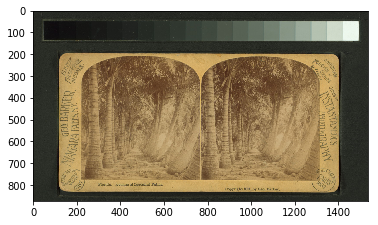

In [11]:
image_number = 12
image_list = t.get_list_of_images('/Volumes/Zweiter/VVR/FL/')
this_image = io.imread('/Volumes/Zweiter/VVR/FL/' + image_list[image_number])
    
plt.imshow(this_image)

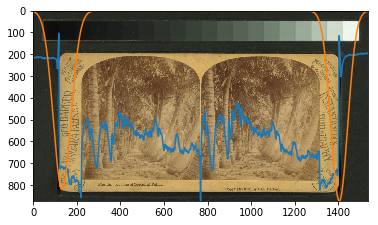

In [12]:
img_luma = t.get_lum_channel(this_image)

x_sums = t.get_luma_sums(img_luma, 'width')
x_sums_max = np.max(x_sums)
x_sums_norm = x_sums / x_sums_max

x_bias = t.get_pdf_x(img_luma.shape[1])
x_bias_max = np.max(x_bias)
x_bias_norm = x_bias / x_bias_max

x_biased = x_sums_norm * x_bias_norm

height = this_image.shape[0]

x_sums_scaled = x_sums_norm * height
x_biased_scaled = x_bias_norm * height

fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(x_sums_scaled)
ax1.plot(x_biased_scaled)
plt.imshow(this_image)

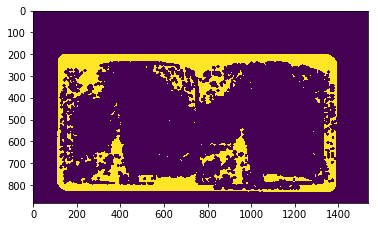

In [4]:
binary = t.get_card_bndbox(this_image)
plt.imshow(binary)

In [18]:
card_bbox = t.get_card_bndbox(this_image)

img_card = this_image[card_bbox[0]:card_bbox[1],card_bbox[0]:card_bbox[1]]

plt.imshow(img_card)

TypeError: only integer scalar arrays can be converted to a scalar index

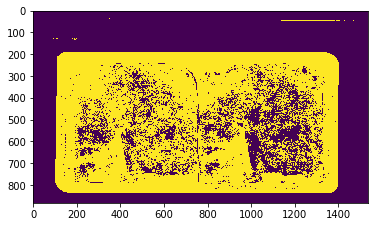

In [4]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(binary)
new_binary = binary > thresh

plt.imshow(new_binary)

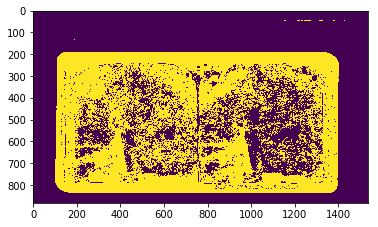

In [5]:
from skimage.filters import threshold_minimum

thresh_min = threshold_minimum(binary)
binary_min = binary > thresh_min

plt.imshow(binary_min)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

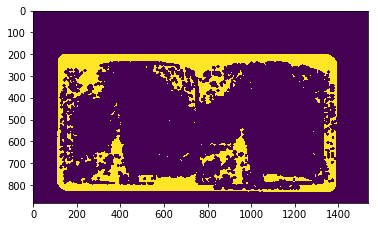

In [12]:
from skimage.morphology import disk, erosion
from scipy import ndimage

mo_disk = skimage.morphology.disk(7)
eroded = skimage.morphology.erosion(new_binary, mo_disk)

plt.imshow(eroded)

img_labled = ndimage.label(eroded)
objects = ndimage.find_objects(img_labled)

print(objects)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


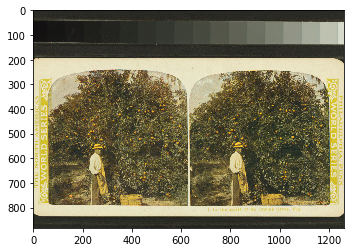

In [4]:
peaks = t.get_max_peaks(this_image)
cropped_image = this_image[:,peaks[0]:peaks[1]]

plt.imshow(cropped_image)

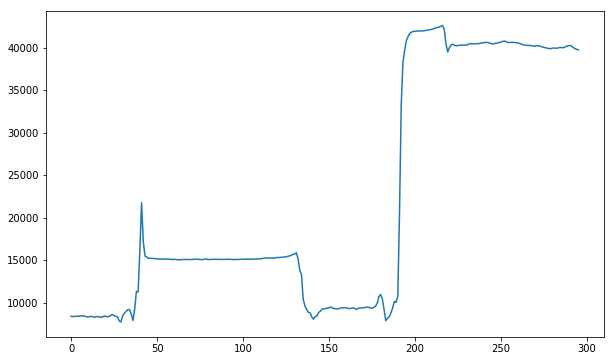

In [16]:
partial = t.get_partial_peaks(this_image, 'height', 0)
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 6))
ax1.plot(partial)

In [15]:
test_image = io.imread('./tests/data/test_wide.png')
gray_image = t.get_lum_channel(test_image)
sample = t.get_partial_peaks(test_image, 'width', 0)
sums = t.get_luma_sums(gray_image, 'width')
test = t.smooth_values(sums)
print(test)

[ 300.  300.  300.  300.  300.  300.  300.  300.  300.    0.    0.    0.
    0.    0.    0.    0.    0.    0.  300.  300.  300.  300.  300.  300.
  300.  300.  300.]


In [13]:
img_luma = t.get_lum_channel(this_image)

width_sums = t.get_luma_sums(img_luma, 'width')
width_binary = t.make_luma_binary(width_sums, 'width')

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 6))
# ax1.imshow(this_image)
# ax1.plot(t.make_luma_binary(width_sums)*800)
# ax1.plot(width_sums)
first_third = t.get_end_third(width_sums, 0)
ax1.plot(first_third)

IndexError: tuple index out of range

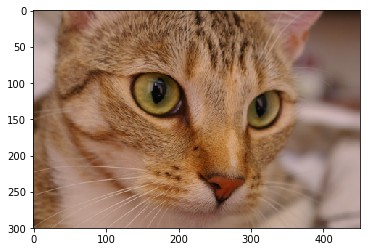

In [3]:
import skimage.data
img = skimage.data.chelsea()
middle = t.get_mid_section(img, 'tall')
plt.imshow(img)